# Data Cleaning

This notebook explores our "messy" data, the list of 11,000+ citations that had no DOI associated with them.

In [188]:
import csv
import pandas as pd
from time import sleep
from datetime import datetime as dt
import re
import os
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

## Import file
Read in the file of "messy" data, "no_doi.csv"

In [4]:
nodoi = pd.read_csv("no_doi.csv", encoding="ISO-8859-1")
nodoi

,ï»¿Author,Year,Title
0,Zhang YF,2014,NaN
1,___,2001,______
2,???,1997,??
3,âÂ©Â¬Ã´Â¬Ã âÂ©Â¬Â¢Â¬Ã´,2007,Chinese Science Bulletin]
4,Hong Song-You,2006,[Asia-Pacific Journal of Atmospheric Sciences
...,...,...,...
11276,Wiscombe W. J.,NCARTN140,NaN
11277,World Bank,CLIM CHANG KNOWL POR,NaN
11278,World Health Organization,GUID DRINK WAT QUAL,NaN
11279,Xue A M,CPS SEG BEIJING 2009,NaN


## Count
Group by count to get a sense of the frequency of titles represented.

In [237]:
summary = nodoi['Title'].value_counts().rename_axis('journal_book').reset_index(name='counts')
summary.head(20)

,journal_book,counts
0,[No title captured],338
1,THESIS,160
2,Bulletin of the Seismological Society of America,126
3,Bulletin of the American Meteorological Society,68
4,American Mineralogist,62
5,Journal of Geophysical Research,51
6,AAPG Bulletin,49
7,J CLIMATE,47
8,Q J ROY METEOR SOC,43
9,CLIMATE CHANGE 2007: THE PHYSICAL SCIENCE BASIS,41


In the top 20, we see variations on "Thesis," "Climate Change 2007" and "Climate Change 2013." The last two are heavily cited IPCC reports. The top result is "No title captured" with 338 instances. Rather than clean up all 11,280, we might focus our clean up on these records. If we look back at our original results, it is likely that the addition of the remaining titles will not impact our results, but let's take a look.

# Calculating 80/20 rule for "no DOI" data
The records without DOIs represented about 20% of our total records (11,280/55,580). Let's take a closer look at this 20% to see how it differs from the rest of the results. 

The following 6 cells will help us calculate and graph the 80/20 rule for these records.

In [6]:
summary['cumsum'] = summary['counts'].cumsum()
summary

,journal_book,counts,cumsum
0,[No title captured],338,338
1,THESIS,160,498
2,Bulletin of the Seismological Society of America,126,624
3,Bulletin of the American Meteorological Society,68,692
4,American Mineralogist,62,754
...,...,...,...
7175,SATELLITE ORBITS MOD,1,11176
7176,ACTIVATED CARBON ADS,1,11177
7177,MAULE REGION EARTHQU,1,11178
7178,QESHM GEOLOGICAL MIN,1,11179


In [7]:
summary['titlenum'] = range(1, 1+len(summary))
summary

,journal_book,counts,cumsum,titlenum
0,[No title captured],338,338,1
1,THESIS,160,498,2
2,Bulletin of the Seismological Society of America,126,624,3
3,Bulletin of the American Meteorological Society,68,692,4
4,American Mineralogist,62,754,5
...,...,...,...,...
7175,SATELLITE ORBITS MOD,1,11176,7176
7176,ACTIVATED CARBON ADS,1,11177,7177
7177,MAULE REGION EARTHQU,1,11178,7178
7178,QESHM GEOLOGICAL MIN,1,11179,7179


In [8]:
summary['titlepct'] = 100*(summary.titlenum/7180)
summary

,journal_book,counts,cumsum,titlenum,titlepct
0,[No title captured],338,338,1,0.013928
1,THESIS,160,498,2,0.027855
2,Bulletin of the Seismological Society of America,126,624,3,0.041783
3,Bulletin of the American Meteorological Society,68,692,4,0.055710
4,American Mineralogist,62,754,5,0.069638
...,...,...,...,...,...
7175,SATELLITE ORBITS MOD,1,11176,7176,99.944290
7176,ACTIVATED CARBON ADS,1,11177,7177,99.958217
7177,MAULE REGION EARTHQU,1,11178,7178,99.972145
7178,QESHM GEOLOGICAL MIN,1,11179,7179,99.986072


In [9]:
summary['citationpct'] = 100*summary['cumsum']/(11180)
summary

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,[No title captured],338,338,1,0.013928,3.023256
1,THESIS,160,498,2,0.027855,4.454383
2,Bulletin of the Seismological Society of America,126,624,3,0.041783,5.581395
3,Bulletin of the American Meteorological Society,68,692,4,0.055710,6.189624
4,American Mineralogist,62,754,5,0.069638,6.744186
...,...,...,...,...,...,...
7175,SATELLITE ORBITS MOD,1,11176,7176,99.944290,99.964222
7176,ACTIVATED CARBON ADS,1,11177,7177,99.958217,99.973166
7177,MAULE REGION EARTHQU,1,11178,7178,99.972145,99.982111
7178,QESHM GEOLOGICAL MIN,1,11179,7179,99.986072,99.991055


In [10]:
ind=np.argmin(abs(80.-summary.citationpct))
pctile = summary.titlepct[ind]
pctile

68.85793871866295

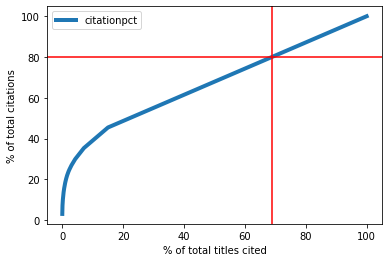

In [11]:
newlines = summary.plot.line(x='titlepct', y='citationpct', linewidth=4)
newlines.axhline(y=80, color='r')
newlines.axvline(x=pctile, color='r')
newlines.set_ylabel('% of total citations')
newlines.set_xlabel('% of total titles cited')
plt.show()

Wow, that's an odd result! It suggests that the "long tail" of citations is varied and each title is only cited once. If we add these records back into the full set, how will the results change? In other words, is it worth it to clean up this long tail?

# Clean up and compare

We've cleaned up the title that occur in the top 20 of the "no doi" list and added them back to the full data set which we will import below as "citedRefsMeta_2".

In [339]:
data = pd.read_csv("citedRefsMeta_2.csv", encoding="ISO-8859-1")
data

,ï»¿Inst,citingDOI,CR,citedDOI,title,journal_book,date,issn1,issn1Type,issn2,issn2Type,isbn
0,Berkeley,NaN,"GAULTIERI N., 1742, INDEX TESTARUM CONCH",NaN,NaN,INDEX TESTARUM CONCH,1742.0,NaN,NaN,NaN,NaN,NaN
1,Berkeley,NaN,"PLANCUS J., 1743, EPISTOLA CONCHIS MEM, Vi, P195",NaN,NaN,EPISTOLA CONCHIS MEM,1743.0,NaN,NaN,NaN,NaN,NaN
2,Berkeley,NaN,"LINNAEUS C. VON, 1758, SYSTEMA NATURAE SIVE, V1",NaN,NaN,SYSTEMA NATURAE SIVE,1758.0,NaN,NaN,NaN,NaN,NaN
3,Berkeley,10.1080/02724634.2017.1306536,"Brisson A. D., 1762, REGNUMANIMALE CLASSE",NaN,NaN,REGNUMANIMALE CLASSE,1762.0,NaN,NaN,NaN,NaN,NaN
4,Berkeley,NaN,"Soldani A., 1789, TESTACEOGRAHIAE AC Z",NaN,NaN,TESTACEOGRAHIAE AC Z,1789.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55575,Berkeley,10.3390/w10030244,"World Health Organization, GUID DRINK WAT QUAL",NaN,NaN,GUID DRINK WAT QUAL,NaN,NaN,NaN,NaN,NaN,NaN
55576,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Xue A M, CPS SEG BEIJING 2009",NaN,NaN,CPS SEG BEIJING 2009,NaN,NaN,NaN,NaN,NaN,NaN
55577,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Zhang P Z, GEOLOGICAL SOC AM B, V102, P1484",NaN,NaN,Geological Society of America Bulletin,NaN,NaN,NaN,NaN,NaN,NaN
55578,Berkeley,10.1016/j.isprsjprs.2014.03.007,"Zhao Y., INT J REMOTE S UNPUB",NaN,NaN,INT J REMOTE S UNPUB,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
data = data.rename(columns={"ï»¿Inst": "Inst"})
data

,Inst,citingDOI,CR,citedDOI,title,journal_book,date,issn1,issn1Type,issn2,issn2Type,isbn
0,Berkeley,NaN,"GAULTIERI N., 1742, INDEX TESTARUM CONCH",NaN,NaN,INDEX TESTARUM CONCH,1742.0,NaN,NaN,NaN,NaN,NaN
1,Berkeley,NaN,"PLANCUS J., 1743, EPISTOLA CONCHIS MEM, Vi, P195",NaN,NaN,EPISTOLA CONCHIS MEM,1743.0,NaN,NaN,NaN,NaN,NaN
2,Berkeley,NaN,"LINNAEUS C. VON, 1758, SYSTEMA NATURAE SIVE, V1",NaN,NaN,SYSTEMA NATURAE SIVE,1758.0,NaN,NaN,NaN,NaN,NaN
3,Berkeley,10.1080/02724634.2017.1306536,"Brisson A. D., 1762, REGNUMANIMALE CLASSE",NaN,NaN,REGNUMANIMALE CLASSE,1762.0,NaN,NaN,NaN,NaN,NaN
4,Berkeley,NaN,"Soldani A., 1789, TESTACEOGRAHIAE AC Z",NaN,NaN,TESTACEOGRAHIAE AC Z,1789.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55575,Berkeley,10.3390/w10030244,"World Health Organization, GUID DRINK WAT QUAL",NaN,NaN,GUID DRINK WAT QUAL,NaN,NaN,NaN,NaN,NaN,NaN
55576,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Xue A M, CPS SEG BEIJING 2009",NaN,NaN,CPS SEG BEIJING 2009,NaN,NaN,NaN,NaN,NaN,NaN
55577,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Zhang P Z, GEOLOGICAL SOC AM B, V102, P1484",NaN,NaN,Geological Society of America Bulletin,NaN,NaN,NaN,NaN,NaN,NaN
55578,Berkeley,10.1016/j.isprsjprs.2014.03.007,"Zhao Y., INT J REMOTE S UNPUB",NaN,NaN,INT J REMOTE S UNPUB,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
cleandata = data['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
cleandata

,journal_book,counts
0,Journal of Geophysical Research,2562
1,Geophysical Research Letters,2478
2,Atmospheric Chemistry and Physics,1341
3,Journal of Climate,1288
4,Science,1225
...,...,...
9666,HANDBOOK,1
9667,GEOLOGIC GEOGRAPHIC,1
9668,COMPTES RENDUS,1
9669,P IEEE 1999 INT GEOS,1


In [133]:
cleandata['journal_book'].isna().sum()

0

In [229]:
cleandata['cumsum'] = cleandata['counts'].cumsum()
cleandata

,journal_book,counts,cumsum
0,Journal of Geophysical Research,2562,2562
1,Geophysical Research Letters,2478,5040
2,Atmospheric Chemistry and Physics,1341,6381
3,Journal of Climate,1288,7669
4,Science,1225,8894
...,...,...,...
9666,HANDBOOK,1,55559
9667,GEOLOGIC GEOGRAPHIC,1,55560
9668,COMPTES RENDUS,1,55561
9669,P IEEE 1999 INT GEOS,1,55562


In [230]:
cleandata['titlenum'] = range(1, 1+len(cleandata))
cleandata

,journal_book,counts,cumsum,titlenum
0,Journal of Geophysical Research,2562,2562,1
1,Geophysical Research Letters,2478,5040,2
2,Atmospheric Chemistry and Physics,1341,6381,3
3,Journal of Climate,1288,7669,4
4,Science,1225,8894,5
...,...,...,...,...
9666,HANDBOOK,1,55559,9667
9667,GEOLOGIC GEOGRAPHIC,1,55560,9668
9668,COMPTES RENDUS,1,55561,9669
9669,P IEEE 1999 INT GEOS,1,55562,9670


In [231]:
cleandata['titlepct'] = 100*(cleandata.titlenum/9671)
cleandata

,journal_book,counts,cumsum,titlenum,titlepct
0,Journal of Geophysical Research,2562,2562,1,0.010340
1,Geophysical Research Letters,2478,5040,2,0.020680
2,Atmospheric Chemistry and Physics,1341,6381,3,0.031021
3,Journal of Climate,1288,7669,4,0.041361
4,Science,1225,8894,5,0.051701
...,...,...,...,...,...
9666,HANDBOOK,1,55559,9667,99.958639
9667,GEOLOGIC GEOGRAPHIC,1,55560,9668,99.968979
9668,COMPTES RENDUS,1,55561,9669,99.979320
9669,P IEEE 1999 INT GEOS,1,55562,9670,99.989660


In [232]:
cleandata['citationpct'] = 100*cleandata['cumsum']/(55563)
cleandata

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Journal of Geophysical Research,2562,2562,1,0.010340,4.610982
1,Geophysical Research Letters,2478,5040,2,0.020680,9.070785
2,Atmospheric Chemistry and Physics,1341,6381,3,0.031021,11.484261
3,Journal of Climate,1288,7669,4,0.041361,13.802350
4,Science,1225,8894,5,0.051701,16.007055
...,...,...,...,...,...,...
9666,HANDBOOK,1,55559,9667,99.958639,99.992801
9667,GEOLOGIC GEOGRAPHIC,1,55560,9668,99.968979,99.994601
9668,COMPTES RENDUS,1,55561,9669,99.979320,99.996400
9669,P IEEE 1999 INT GEOS,1,55562,9670,99.989660,99.998200


# Calculate 80/20 rule
We can recalculate the 80/20 rule below and even with the clean data, we're back under 10%, meaning 80% of citations come from 9.33% of titles.

In [233]:
ind=np.argmin(abs(80.-cleandata.citationpct))
pctile = cleandata.titlepct[ind]
pctile

9.337193671802295

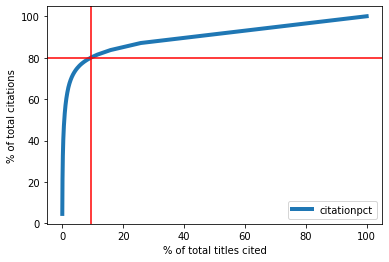

In [234]:
newlines = cleandata.plot.line(x='titlepct', y='citationpct', linewidth=4)
newlines.axhline(y=80, color='r')
newlines.axvline(x=pctile, color='r')
newlines.set_ylabel('% of total citations')
newlines.set_xlabel('% of total titles cited')
plt.show()

We can also compare with our original results to see how things have changed.

In [104]:
citedRefsMeta = pd.read_csv('citedRefsMeta.csv', encoding='utf-8')

In [105]:
citedRefsMeta_count = citedRefsMeta['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_count.head(20)

,journal_book,counts
0,Journal of Geophysical Research,2509
1,Geophysical Research Letters,2451
2,Atmospheric Chemistry and Physics,1310
3,Journal of Climate,1241
4,Science,1225
5,Nature,1077
6,Journal of Geophysical Research: Atmospheres,1045
7,Earth and Planetary Science Letters,827
8,Journal of Geophysical Research: Space Physics,792
9,Journal of the Atmospheric Sciences,734


In [235]:
compare = pd.concat([citedRefsMeta_count['journal_book'], cleandata['journal_book']], axis=1, keys=['citedRefsMeta_count', 'cleandata'])

In [236]:
compare.head(50)

,citedRefsMeta_count,cleandata
0,Journal of Geophysical Research,Journal of Geophysical Research
1,Geophysical Research Letters,Geophysical Research Letters
2,Atmospheric Chemistry and Physics,Atmospheric Chemistry and Physics
3,Journal of Climate,Journal of Climate
4,Science,Science
5,Nature,Nature
6,Journal of Geophysical Research: Atmospheres,Journal of Geophysical Research: Atmospheres
7,Earth and Planetary Science Letters,Earth and Planetary Science Letters
8,Journal of Geophysical Research: Space Physics,Journal of Geophysical Research: Space Physics
9,Journal of the Atmospheric Sciences,Journal of the Atmospheric Sciences


In [226]:
p = citedRefsMeta_count.loc[citedRefsMeta_count['counts'] >= 100]
p

,journal_book,counts
0,Journal of Geophysical Research,2509
1,Geophysical Research Letters,2451
2,Atmospheric Chemistry and Physics,1310
3,Journal of Climate,1241
4,Science,1225
...,...,...
77,Lithos,105
78,Planetary and Space Science,105
79,Earth Surface Processes and Landforms,103
80,Annual Review of Earth and Planetary Sciences,103


In [ ]:
n = cleandata.loc[cleandata['citationpct'] <= 80]
n

In [303]:
time_series = pd.read_csv("citedRefsMeta_2.csv", encoding="ISO-8859-1")
time_series['date'] = pd.to_datetime(time_series['date'], format='%Y').dt.strftime('%Y')
time_series

,ï»¿Inst,citingDOI,CR,citedDOI,title,journal_book,date,issn1,issn1Type,issn2,issn2Type,isbn
0,Berkeley,NaN,"GAULTIERI N., 1742, INDEX TESTARUM CONCH",NaN,NaN,INDEX TESTARUM CONCH,1742,NaN,NaN,NaN,NaN,NaN
1,Berkeley,NaN,"PLANCUS J., 1743, EPISTOLA CONCHIS MEM, Vi, P195",NaN,NaN,EPISTOLA CONCHIS MEM,1743,NaN,NaN,NaN,NaN,NaN
2,Berkeley,NaN,"LINNAEUS C. VON, 1758, SYSTEMA NATURAE SIVE, V1",NaN,NaN,SYSTEMA NATURAE SIVE,1758,NaN,NaN,NaN,NaN,NaN
3,Berkeley,10.1080/02724634.2017.1306536,"Brisson A. D., 1762, REGNUMANIMALE CLASSE",NaN,NaN,REGNUMANIMALE CLASSE,1762,NaN,NaN,NaN,NaN,NaN
4,Berkeley,NaN,"Soldani A., 1789, TESTACEOGRAHIAE AC Z",NaN,NaN,TESTACEOGRAHIAE AC Z,1789,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55575,Berkeley,10.3390/w10030244,"World Health Organization, GUID DRINK WAT QUAL",NaN,NaN,GUID DRINK WAT QUAL,NaN,NaN,NaN,NaN,NaN,NaN
55576,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Xue A M, CPS SEG BEIJING 2009",NaN,NaN,CPS SEG BEIJING 2009,NaN,NaN,NaN,NaN,NaN,NaN
55577,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Zhang P Z, GEOLOGICAL SOC AM B, V102, P1484",NaN,NaN,Geological Society of America Bulletin,NaN,NaN,NaN,NaN,NaN,NaN
55578,Berkeley,10.1016/j.isprsjprs.2014.03.007,"Zhao Y., INT J REMOTE S UNPUB",NaN,NaN,INT J REMOTE S UNPUB,NaN,NaN,NaN,NaN,NaN,NaN


In [330]:
sorted = time_series['date'].value_counts().rename_axis('date').reset_index(name='counts')
sorted = sorted.sort_values('date', ascending=False)

<function matplotlib.pyplot.show(*args, **kw)>

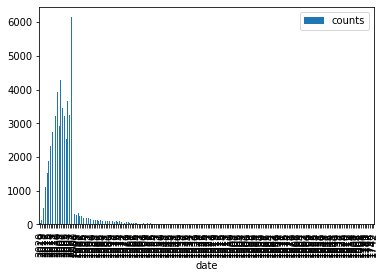

In [331]:
sorted.plot(x='date', y='counts',kind="bar")
plt.show

In [349]:
citedRefsMeta_ucb = data.loc[data['Inst'] == 'Berkeley']
citedRefsMeta_ucb_count = citedRefsMeta_ucb['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_ucb_count['cumsum'] = citedRefsMeta_ucb_count['counts'].cumsum()
citedRefsMeta_ucb_count['titlenum'] = range(1, 1+len(citedRefsMeta_ucb_count))
citedRefsMeta_ucb_count['titlenum']

0          1
1          2
2          3
3          4
4          5
        ... 
4317    4318
4318    4319
4319    4320
4320    4321
4321    4322
Name: titlenum, Length: 4322, dtype: int64

In [350]:
citedRefsMeta_ucb_count['titlepct'] = 100*(citedRefsMeta_ucb_count.titlenum/1595)
citedRefsMeta_ucb_count

,journal_book,counts,cumsum,titlenum,titlepct
0,Journal of Geophysical Research,558,558,1,0.062696
1,Geophysical Research Letters,477,1035,2,0.125392
2,Earth and Planetary Science Letters,339,1374,3,0.188088
3,Science,324,1698,4,0.250784
4,Nature,321,2019,5,0.313480
...,...,...,...,...,...
4317,International Journal of Water Resources Devel...,1,16843,4318,270.721003
4318,IDS Bulletin,1,16844,4319,270.783699
4319,J LAND USE ENV LAW,1,16845,4320,270.846395
4320,INT C HEAV MET ENV G,1,16846,4321,270.909091


In [351]:
citedRefsMeta_ucb_count['citationpct'] = 100*citedRefsMeta_ucb_count['cumsum']/(12979)
citedRefsMeta_ucb_count

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Journal of Geophysical Research,558,558,1,0.062696,4.299253
1,Geophysical Research Letters,477,1035,2,0.125392,7.974420
2,Earth and Planetary Science Letters,339,1374,3,0.188088,10.586332
3,Science,324,1698,4,0.250784,13.082672
4,Nature,321,2019,5,0.313480,15.555898
...,...,...,...,...,...,...
4317,International Journal of Water Resources Devel...,1,16843,4318,270.721003,129.771169
4318,IDS Bulletin,1,16844,4319,270.783699,129.778874
4319,J LAND USE ENV LAW,1,16845,4320,270.846395,129.786578
4320,INT C HEAV MET ENV G,1,16846,4321,270.909091,129.794283


In [352]:
ind=np.argmin(abs(80.-citedRefsMeta_ucb_count.citationpct))
pctile_ucb = citedRefsMeta_ucb_count.titlepct[ind]
pctile_ucb

13.60501567398119